Kullanılan Cihaz: cuda
Seçilen Sınıf: At (Horse)
Bu sınıfa ait toplam görüntü sayısı: 5000
Eğitim Başlıyor...
[1/50]	Loss_D: 0.2708	Loss_G: 6.7182
[2/50]	Loss_D: 0.1097	Loss_G: 4.6011
[3/50]	Loss_D: 0.8486	Loss_G: 6.4670
[4/50]	Loss_D: 0.9313	Loss_G: 4.3882
[5/50]	Loss_D: 0.4596	Loss_G: 4.8444
[6/50]	Loss_D: 0.5371	Loss_G: 6.0174
[7/50]	Loss_D: 0.4145	Loss_G: 3.8472
[8/50]	Loss_D: 0.2947	Loss_G: 4.1112
[9/50]	Loss_D: 0.4033	Loss_G: 4.1945
[10/50]	Loss_D: 0.1842	Loss_G: 5.3015
[11/50]	Loss_D: 0.2328	Loss_G: 5.2037
[12/50]	Loss_D: 1.2140	Loss_G: 9.3933
[13/50]	Loss_D: 0.5825	Loss_G: 3.2875
[14/50]	Loss_D: 0.5358	Loss_G: 2.6658
[15/50]	Loss_D: 0.3371	Loss_G: 5.0524
[16/50]	Loss_D: 0.1932	Loss_G: 4.2357
[17/50]	Loss_D: 0.3154	Loss_G: 4.7248
[18/50]	Loss_D: 0.1911	Loss_G: 5.0158
[19/50]	Loss_D: 0.1327	Loss_G: 4.2049
[20/50]	Loss_D: 0.3007	Loss_G: 5.3453
[21/50]	Loss_D: 0.2524	Loss_G: 4.3561
[22/50]	Loss_D: 0.2426	Loss_G: 3.8211
[23/50]	Loss_D: 0.3779	Loss_G: 2.6883
[24/50]	Loss_D: 0.2742	Lo

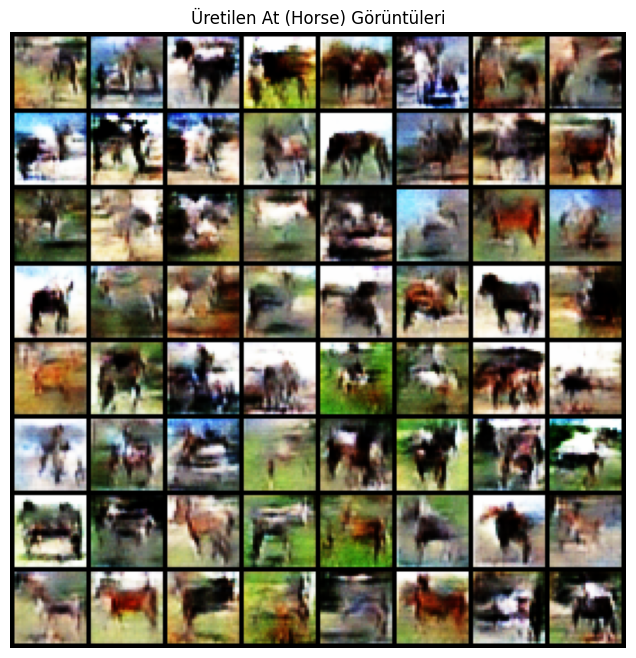

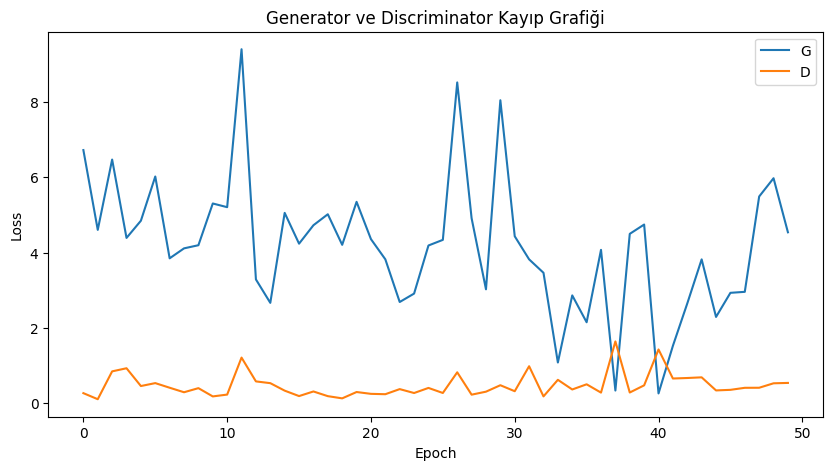

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Ayarlar ve Hiperparametreler ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

# Seçilen Sınıf İndeksi (CIFAR-10)
# 0:Uçak, 1:Otomobil, 2:Kuş, 3:Kedi, 4:Geyik, 
# 5:Köpek, 6:Kurbağa, 7:At, 8:Gemi, 9:Kamyon
TARGET_CLASS_INDEX = 7 # AT (Horse)
CLASS_NAME = "At (Horse)"

BATCH_SIZE = 128
IMAGE_SIZE = 32 # CIFAR-10 boyutu
Z_DIM = 100     # Latent vektör boyutu
LR = 0.0002     # DCGAN için standart learning rate
BETA1 = 0.5     # Adam optimizer momentumu
NUM_EPOCHS = 50 # İyi sonuç için en az 20-50 arası gerekir

# --- 2. Veri Seti Hazırlama (Sınıf Filtreleme) ---
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [-1, 1] aralığına
])

# Tüm veri setini indir
full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Sadece hedef sınıfı filtrele
# (Target indeksi bizim seçtiğimiz sınıfa eşit olanları al)
indices = [i for i, target in enumerate(full_dataset.targets) if target == TARGET_CLASS_INDEX]
target_dataset = Subset(full_dataset, indices)

dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"Seçilen Sınıf: {CLASS_NAME}")
print(f"Bu sınıfa ait toplam görüntü sayısı: {len(target_dataset)}")

# --- 3. DCGAN Mimarisi ---

# Ağırlık Başlatma (DCGAN makalesine göre)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Girdi: Z_DIM x 1 x 1
        self.main = nn.Sequential(
            # 1. Katman: 100 -> 4x4 boyutuna çıkış
            nn.ConvTranspose2d(Z_DIM, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # 2. Katman: 4x4 -> 8x8 boyutuna çıkış
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # 3. Katman: 8x8 -> 16x16 boyutuna çıkış
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # 4. Katman: 16x16 -> 32x32 boyutuna çıkış (Görüntü)
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh() # Renkler [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1. Katman: 32x32 -> 16x16 (Stride=2 ile küçültme)
            # Discriminator'ın girişinde BatchNorm önerilmez
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 2. Katman: 16x16 -> 8x8
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 3. Katman: 8x8 -> 4x4
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 4. Katman: 4x4 -> 1x1 (Skaler Çıktı)
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Modelleri oluştur ve ağırlıkları başlat
netG = Generator().to(device)
netG.apply(weights_init)

netD = Discriminator().to(device)
netD.apply(weights_init)

# Optimizer ve Loss
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

# Sabit gürültü (Gelişimi izlemek için)
fixed_noise = torch.randn(64, Z_DIM, 1, 1, device=device)

# --- 4. Eğitim Döngüsü ---
print("Eğitim Başlıyor...")
img_list = []
G_losses = []
D_losses = []

for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(dataloader, 0):
        # --- (1) Discriminator Güncellemesi: log(D(x)) + log(1 - D(G(z))) ---
        netD.zero_grad()
        
        # Gerçek verilerle eğit
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device) # Etiket: 1
        
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        
        # Sahte verilerle eğit
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.) # Etiket: 0
        
        output = netD(fake.detach()).view(-1) # Detach önemli!
        errD_fake = criterion(output, label)
        errD_fake.backward()
        
        errD = errD_real + errD_fake
        optimizerD.step()

        # --- (2) Generator Güncellemesi: log(D(G(z))) ---
        netG.zero_grad()
        label.fill_(1.) # Generator için hedef "Gerçek(1)" olarak algılanmak
        
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    # İstatistikler
    print(f'[{epoch+1}/{NUM_EPOCHS}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}')
    
    G_losses.append(errG.item())
    D_losses.append(errD.item())

print("Eğitim Tamamlandı.")

# --- 5. Sonuçları Görselleştirme ---
# En son model ile görüntü üret
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()

# Görüntüleri ızgara (grid) yap
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title(f"Üretilen {CLASS_NAME} Görüntüleri")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))
plt.show()

# Kayıp Grafiği
plt.figure(figsize=(10,5))
plt.title("Generator ve Discriminator Kayıp Grafiği")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

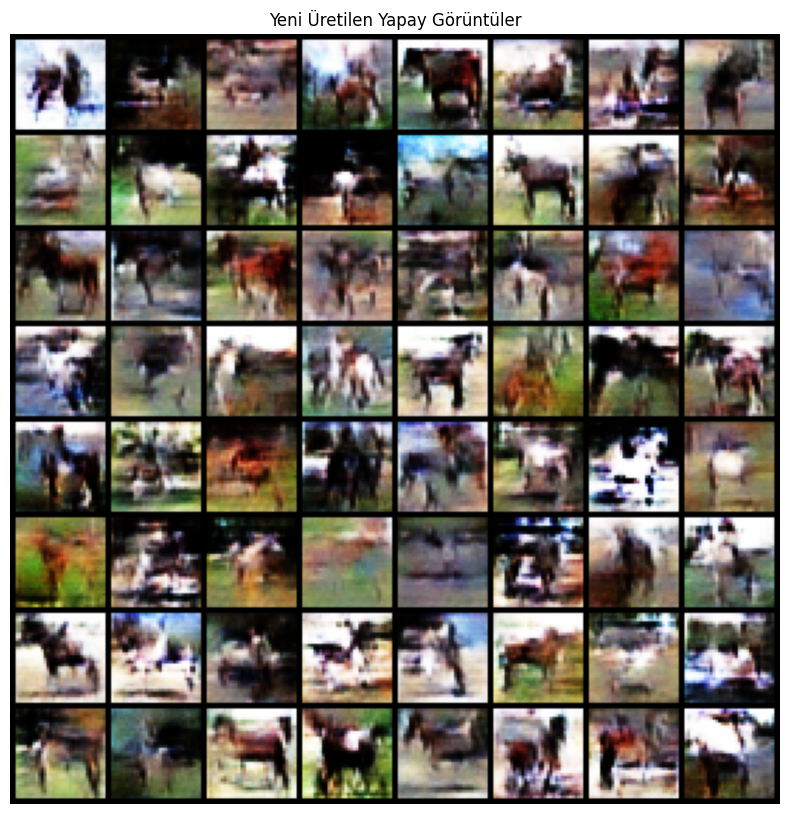

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

def generate_new_images(generator, num_images=64, z_dim=100, device='cuda'):
    """
    Eğitilmiş Generator modelinden yeni görüntüler üretir ve görselleştirir.
    
    Args:
        generator: Eğitilmiş Generator modeli
        num_images: Üretilecek görüntü sayısı
        z_dim: Gürültü vektörü boyutu (Latent dimension)
        device: 'cuda' veya 'cpu'
    """
    # 1. Modeli değerlendirme moduna al (BatchNorm vb. sabitler)
    generator.eval()
    
    # 2. Rastgele Gürültü (Latent Vector) Oluştur
    # DCGAN giriş olarak (Batch, Z, 1, 1) bekler
    noise = torch.randn(num_images, z_dim, 1, 1, device=device)
    
    # 3. Görüntüleri Üret
    with torch.no_grad():
        fake_images = generator(noise).detach().cpu()
    
    # 4. Görselleştirme
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Yeni Üretilen Yapay Görüntüler")
    
    # Görüntüleri ızgara (grid) haline getir
    # padding=2: Resimler arası boşluk
    # normalize=True: [-1, 1] aralığındaki pikselleri [0, 1] yaparak düzgün görünmesini sağlar
    grid_img = vutils.make_grid(fake_images, padding=2, normalize=True)
    
    # PyTorch (C, H, W) -> Matplotlib (H, W, C) dönüşümü
    plt.imshow(np.transpose(grid_img, (1, 2, 0)))
    plt.show()

# --- KULLANIM ---
# Eğer eğitimden hemen sonra çalıştırıyorsanız 'netG' modelini ve 'device'ı doğrudan kullanabilirsiniz.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 64 adet yeni resim üret
generate_new_images(netG, num_images=64, z_dim=100, device=device)